In [1]:
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.naive_bayes import GaussianNB # GNB
from sklearn import model_selection # for model selection during training
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Train data
training_data = pd.read_csv(r"datasets\training.csv")
print('\nHead of training data:\n')
print(training_data.head())



Head of training data:

   Label                                              Query
0      1                         q+Z8AnwaBA.hidemyself.org.
1      1                         q+Z8A3wbBA.hidemyself.org.
2      1                         q+Z8BHwcBA.hidemyself.org.
3      1                         q+Z8BXwdBA.hidemyself.org.
4      1  q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...


In [3]:
training_data.head()

,Label,Query
0,1,q+Z8AnwaBA.hidemyself.org.
1,1,q+Z8A3wbBA.hidemyself.org.
2,1,q+Z8BHwcBA.hidemyself.org.
3,1,q+Z8BXwdBA.hidemyself.org.
4,1,q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...


In [3]:
# Test data
test_data = pd.read_csv(r"datasets\validating.csv")
print('\nHead of test data:\n')
print(test_data.head())



Head of test data:

   Label                                              Query
0      1                         q+aJ04nrBA.hidemyself.org.
1      1                         q+aJ1InsBA.hidemyself.org.
2      1                         q+aJ1YntBA.hidemyself.org.
3      1  q+aJ1onuCDT2aA0NEkzbTnzRPgWJE7aYtQhjcSmnj74ufU...
4      1  q+aJ14nvCHKAcMCkiIhCb3eY1s8cgWt39jSJuK4299f/S5...


1    12000
0     3000
Name: Label, dtype: int64


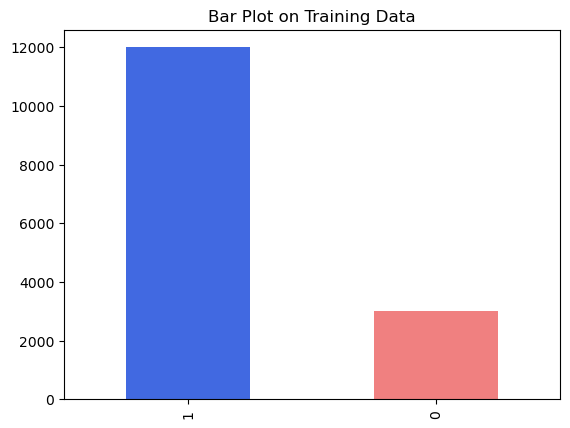

In [4]:
# Preliminary analysis of the database to be used 
counts = training_data['Label'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["royalblue","lightcoral"])
plt.title('Bar Plot on Training Data')
plt.show()

1    4000
0    1000
Name: Label, dtype: int64


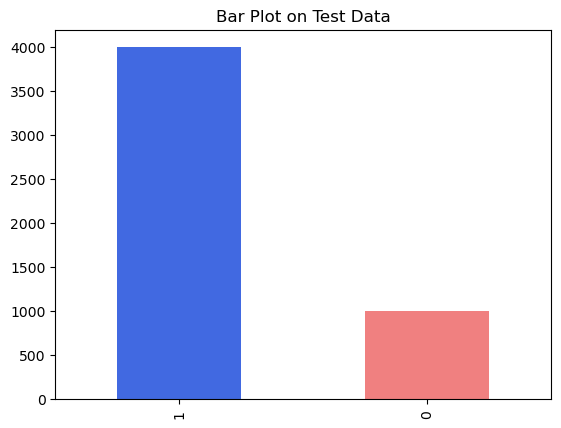

In [5]:
counts = test_data['Label'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["royalblue","lightcoral"])
plt.title('Bar Plot on Test Data')
plt.show()


In [6]:
def calculate_entropy(text):
    if not text: 
        return 0 
    
    entropy = 0

    # Each char has 256 possible values
    for x in range(256): 
        # Calc prob of that symbol
        p_x = float(text.count(chr(x)))/len(text) 
        if p_x > 0: 
            # shannon formula
            entropy += - p_x*math.log(p_x, 2) 
    return entropy


In [7]:
entropy_train_vals = []


In [8]:
for query in training_data['Query']:
    entropy = calculate_entropy(query)
    entropy_train_vals.append(entropy)
    
training_data['Entropy'] = entropy_train_vals

In [9]:
entropy_test_vals = []

In [10]:
for query in test_data['Query']:
    entropy = calculate_entropy(query)
    entropy_test_vals.append(entropy)

test_data['Entropy'] = entropy_test_vals

In [11]:
def evaluate(predictions, targets):
    targets = targets.to_numpy()
    
    tp = 0; tn = 0; fp = 0; fn = 0;
    
    for t in range(targets.shape[0]):
        if targets[t] == -1:
            if predictions[t] == 1:
                fp += 1
            else:
                tn += 1
        else:
            if predictions[t] == 1:
                tp += 1
            else:
                fn += 1

    print("True Positives :", tp)
    print("True Negatives :", tn)
    print("False Positives :", fp)
    print("False Negatives :", fn)


In [28]:
training_data

,Label,Query,Entropy
0,1,q+Z8AnwaBA.hidemyself.org.,4.363713
1,1,q+Z8A3wbBA.hidemyself.org.,4.363713
2,1,q+Z8BHwcBA.hidemyself.org.,4.363713
3,1,q+Z8BXwdBA.hidemyself.org.,4.286790
4,1,q+Z8BnweCORdAGL4+W7DB5xH1cUwcwM1gejAQoJF8hbs2J...,5.752803
...,...,...,...
14995,1,r17800.tunnel.tuns.org.,3.621176
14996,1,dIUEABDEGR5AAAQAGT7IAUAAAAMFAAAAC37CAAFUWW5W36...,5.045887
14997,1,r17801.tunnel.tuns.org.,3.621176
14998,1,dIUEABDEGSBAAAQAGT7HQUAAAAMFAAAAC37CAAFUWW5XBO...,5.084584


In [12]:
# Pre-process input data
X_train = training_data['Entropy'] # the training input entropy
Y_train = training_data['Label']   # the corresponding classifying label for training
X_train, Y_train = shuffle(X_train, Y_train) # to reduce overfitting during training
X_train.ravel()
# We have to reshape the training features into unknown rows but 1 column
X_train = X_train.values.reshape(-1, 1)
Y_train = Y_train.values.reshape(-1, 1)


In [13]:
# We have to do the same with the test values 
X_test = test_data['Entropy']      # the test entropy for testing
Y_test = test_data['Label']       # the expected corresponding Label after training
X_test, Y_test = shuffle(X_test, Y_test)
X_test  = X_test.values.reshape(-1, 1)

In [14]:
seed = 7
models = []
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 2)))


In [15]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
dfs = []
target_names = ['fail', 'passed']


In [16]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=200, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_validate(model, X_train, Y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print(name)
    print(classification_report(Y_test, y_pred, target_names=target_names))
    
    results.append(cv_results)
    names.append(name)

    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

DTC
              precision    recall  f1-score   support

        fail       1.00      0.99      1.00      1000
      passed       1.00      1.00      1.00      4000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

GNB
              precision    recall  f1-score   support

        fail       0.69      0.95      0.80      1000
      passed       0.99      0.89      0.94      4000

    accuracy                           0.90      5000
   macro avg       0.84      0.92      0.87      5000
weighted avg       0.93      0.90      0.91      5000

KNN
              precision    recall  f1-score   support

        fail       1.00      0.99      0.99      1000
      passed       1.00      1.00      1.00      4000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [17]:
model_list = list(set(final.model.values))
model_list.sort()

In [18]:
model_list

['DTC', 'GNB', 'KNN']

In [19]:
bootstraps = []

In [20]:
for model in model_list:
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)

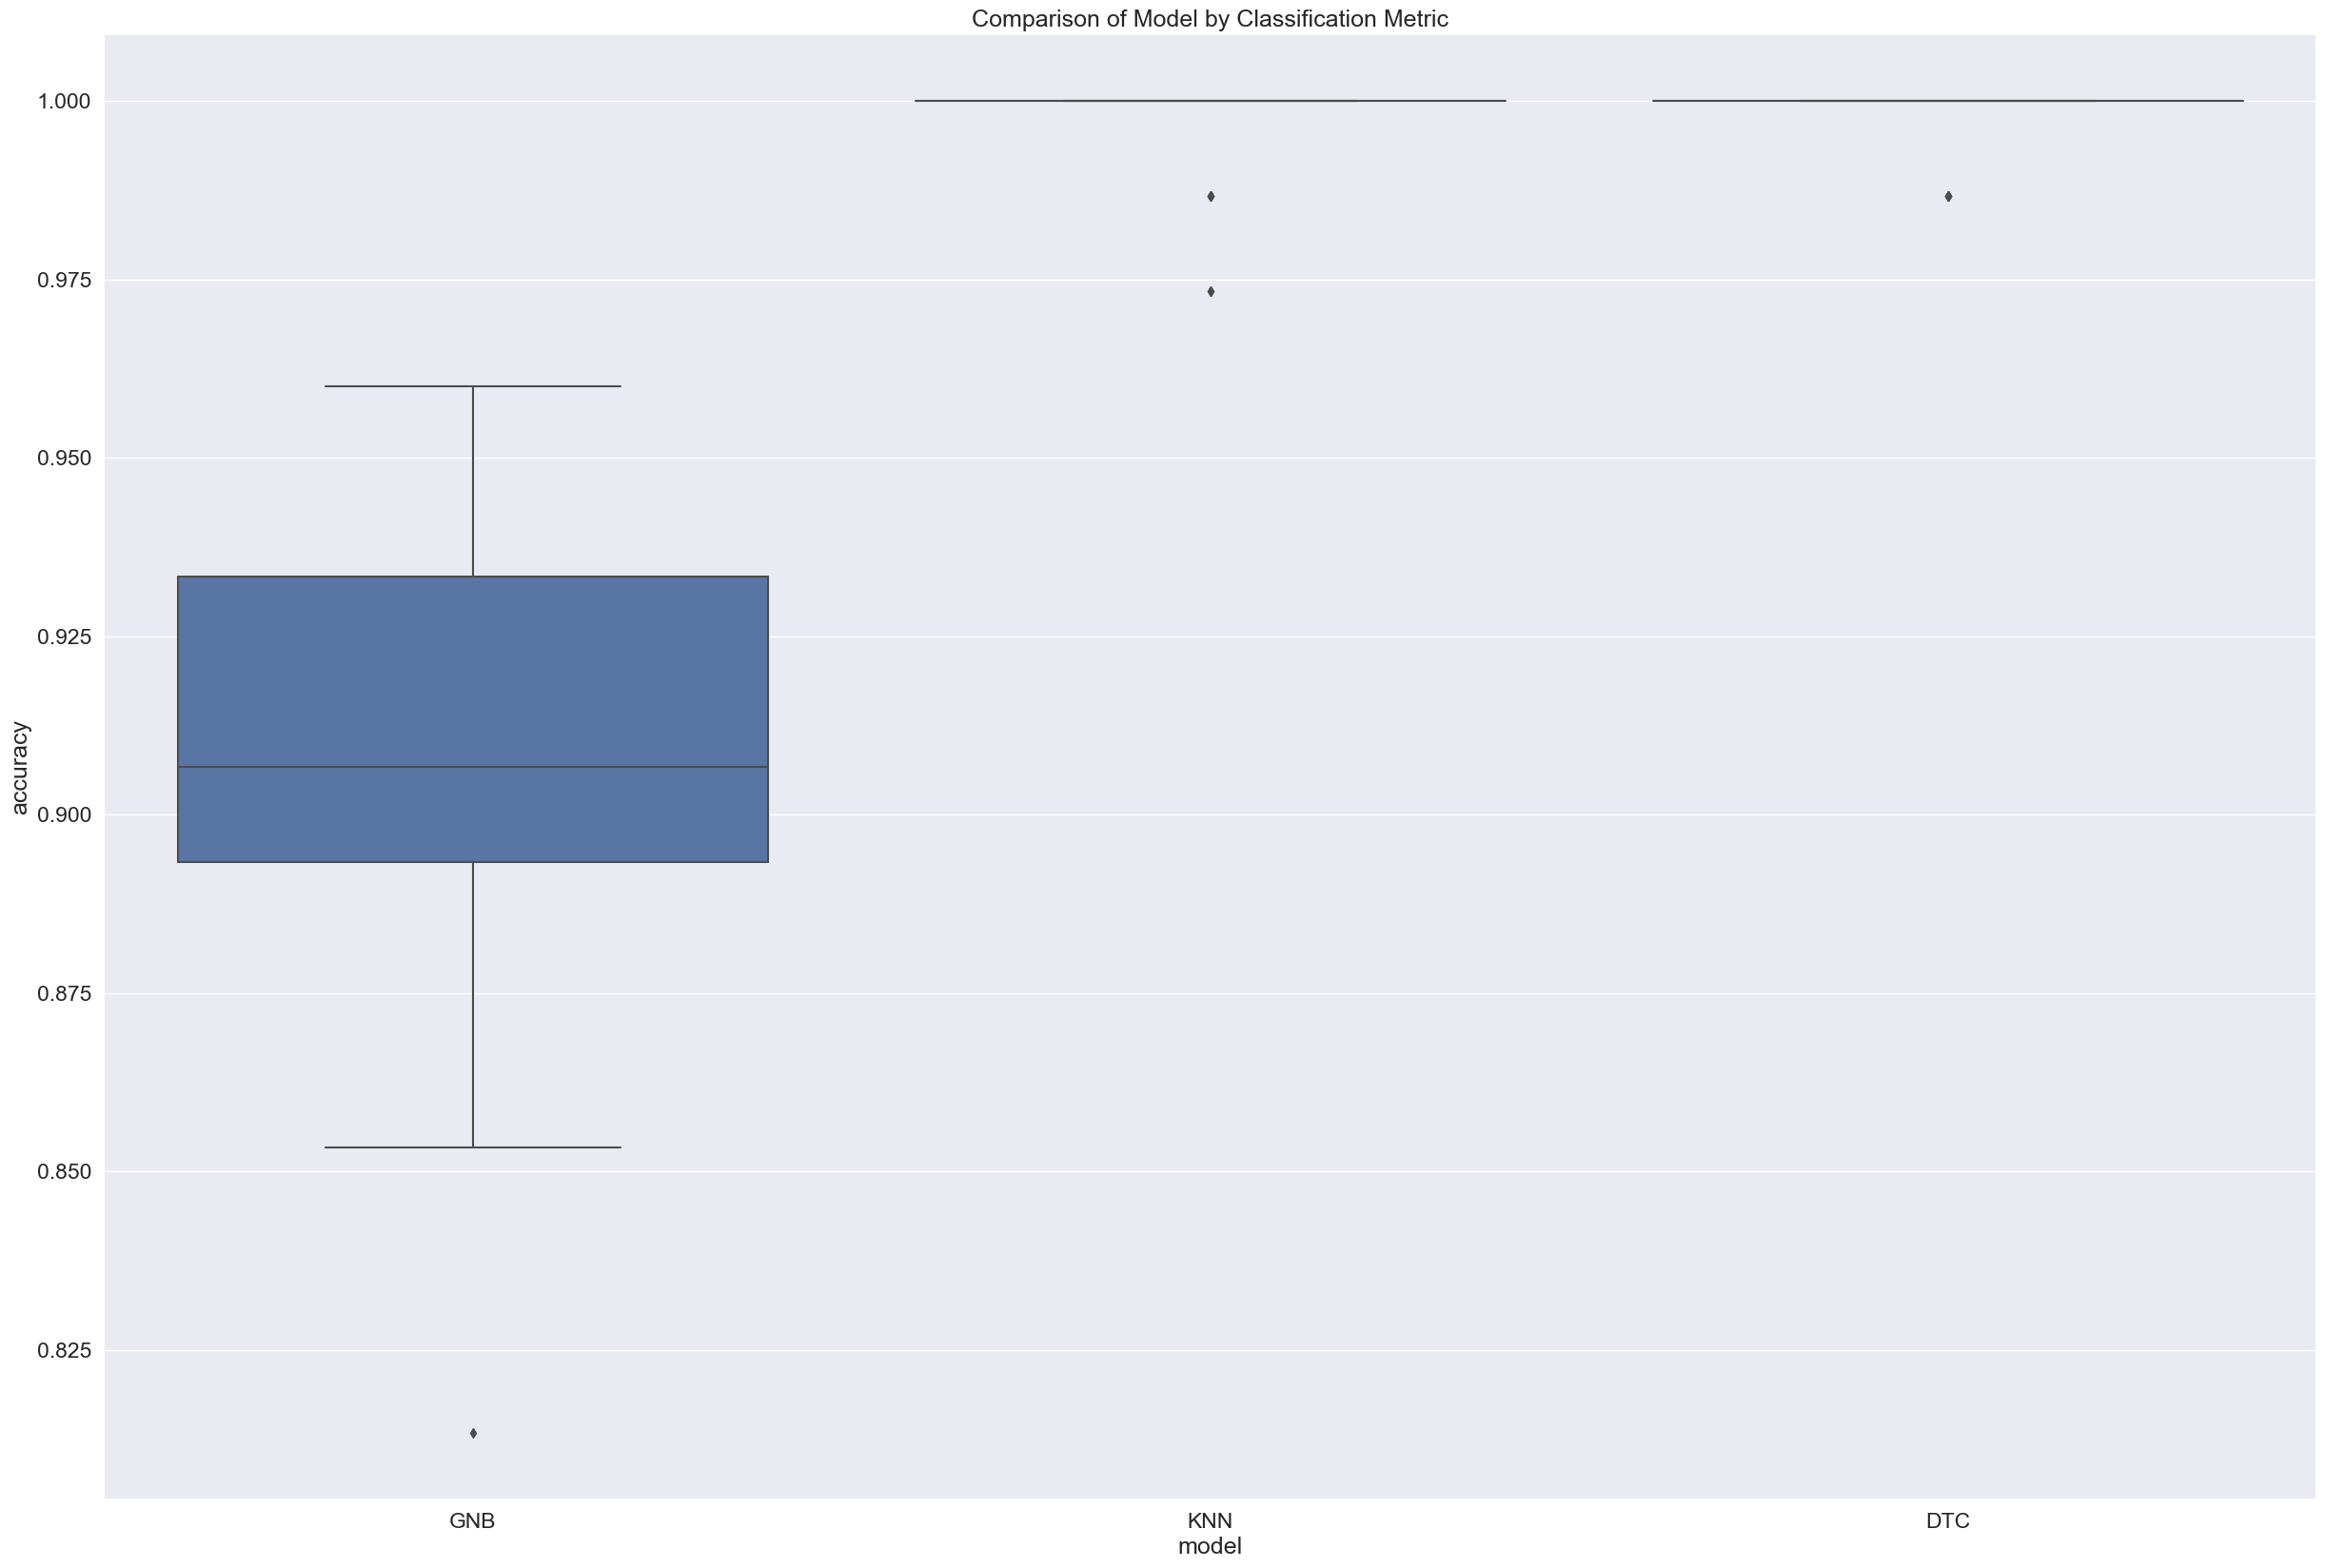

In [21]:
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='accuracy')
time_metrics = ['fit_time','score_time'] # fit time metrics
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='accuracy')
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='accuracy')
plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
g = sns.boxplot(x="model", y="accuracy", data=results_long_nofit)
plt.title('Comparison of Model by Classification Metric')
plt.show()

TIME consu:  13.41867446899414 millisec
True Positives : 4116
True Negatives : 0
False Positives : 0
False Negatives : 884
Detection Accuracy:  97.64 %


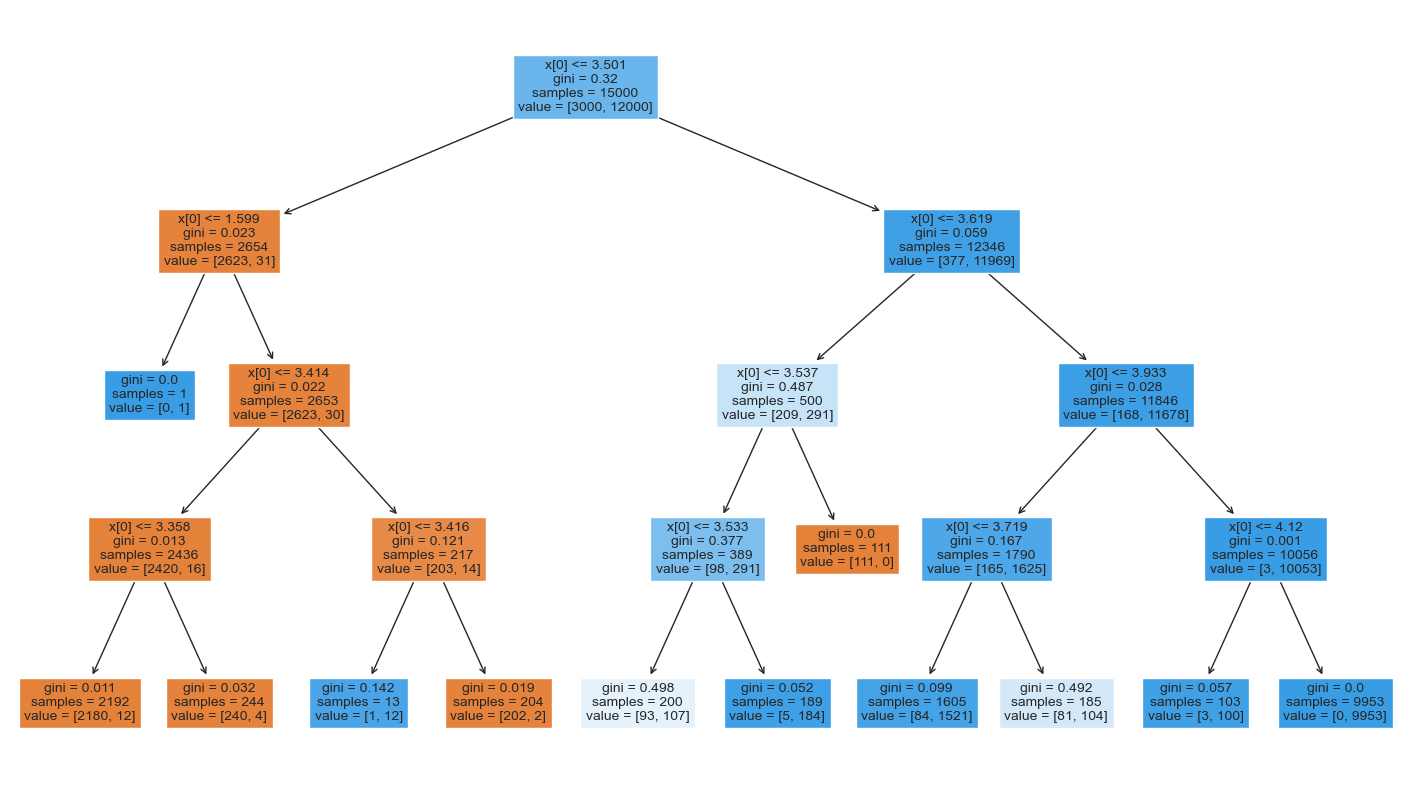

In [22]:
X_train, Y_train = shuffle(X_train, Y_train) # to reduce overfitting during training
start = time.time()
model = DecisionTreeClassifier(max_depth=4)   
model.fit(X_train, Y_train.ravel())
end = time.time()
dtc_time = (end-start)*1000
print("TIME consu: ", dtc_time,"millisec")
y_preds = model.predict(X_test)
evaluate(y_preds, Y_test)
dtc_acc = accuracy_score(Y_test, y_preds)*100
print("Detection Accuracy: ",dtc_acc,"%")

plt.figure(figsize=(18,10))
tree.plot_tree(model, filled=True, fontsize=10)
plt.show()

TIME cons  121.8416690826416 millisec
True Positives : 4006
True Negatives : 0
False Positives : 0
False Negatives : 994
Detection Accuracy:  99.8 %


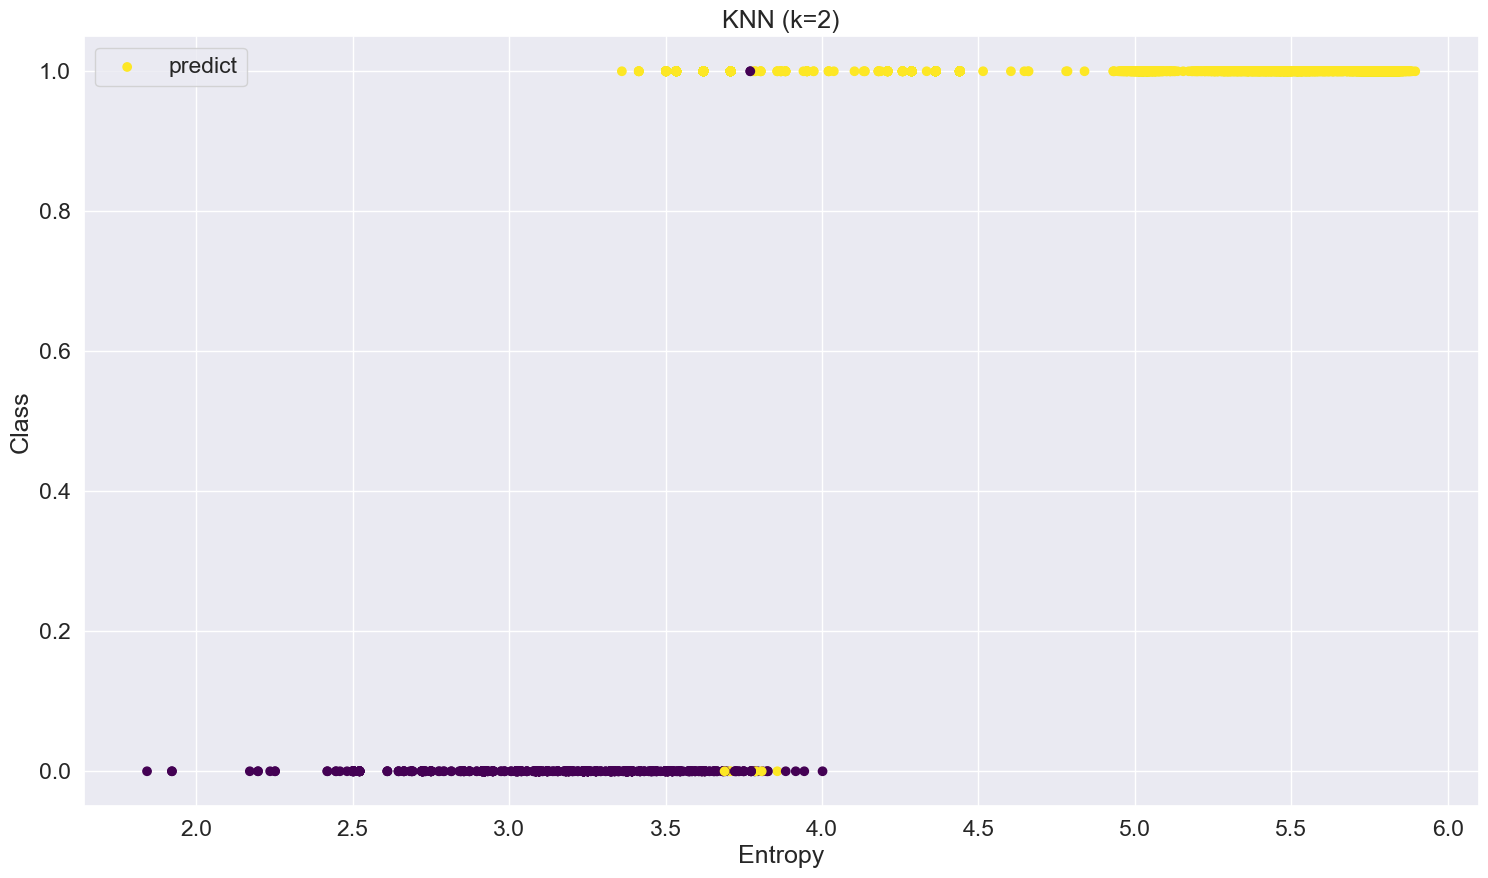

In [23]:
# KNN ( neighbors == 2)
start = time.time()
knn_model = KNeighborsClassifier(n_neighbors = 2)
y_preds = knn_model.fit(X_train, Y_train.ravel()).predict(X_test)
end = time.time()
knn_time = (end-start)*1000
print("TIME cons ", knn_time,"millisec")
y_preds = knn_model.predict(X_test)
evaluate(y_preds, Y_test)
knn_acc = accuracy_score(Y_test, y_preds)*100
print("Detection Accuracy: ",knn_acc,"%")
plt.figure(figsize=(18,10))
#plt.scatter(X_test, Y_test, label='real', color='blue', marker='o')
plt.scatter(X_test, Y_test, label='predict', c=y_preds, cmap='viridis', marker='o')
plt.title('KNN (k=2)')
plt.xlabel('Entropy')
plt.ylabel('Class')
plt.legend()
plt.show()

In [24]:
# GaussianNB
start = time.time()
gnb_model = GaussianNB()
y_preds = gnb_model.fit(X_train, Y_train.ravel())
y_preds = gnb_model.predict(X_test)
end = time.time()
gnb_time = (end-start)*1000
print("TIME cons: ", gnb_time,"millisec")
y_preds = gnb_model.predict(X_test)
evaluate(y_preds, Y_test)
gnb_acc = accuracy_score(Y_test, y_preds)*100
print("Detection Accuracy: ",gnb_acc,"%")


TIME cons:  4.345178604125977 millisec
True Positives : 3624
True Negatives : 0
False Positives : 0
False Negatives : 1376
Detection Accuracy:  90.36 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['DTC', 'GNB', 'KNN']


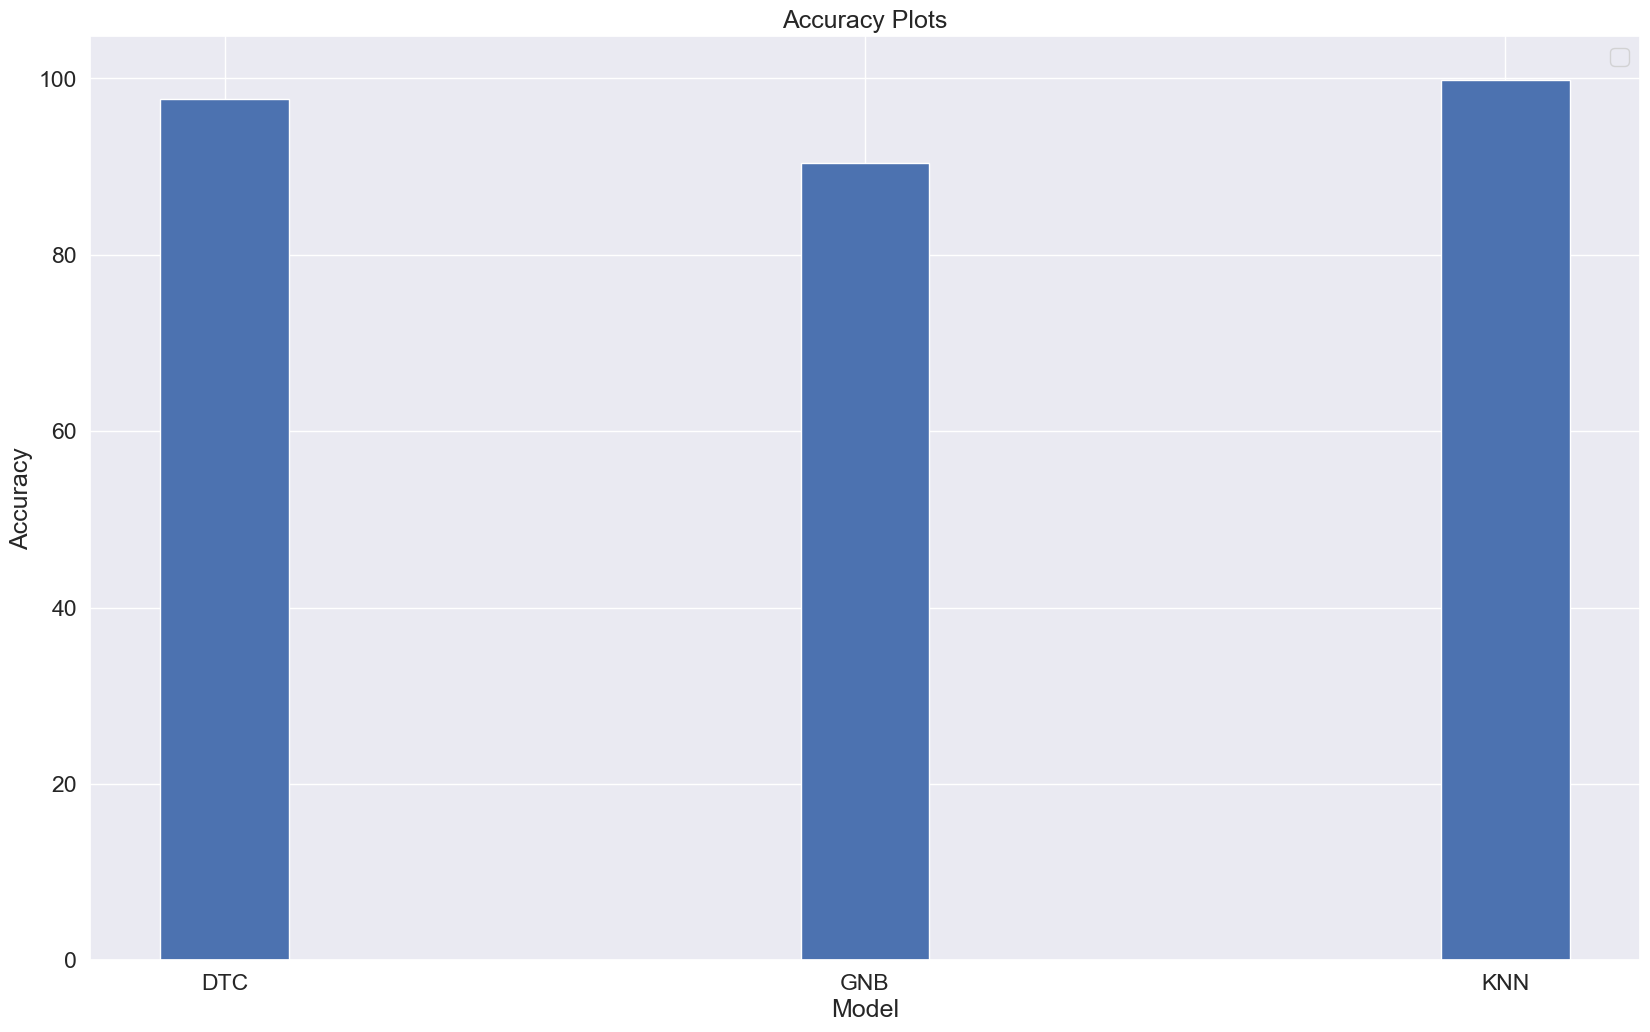

In [25]:
# Final plot
accuracies = [dtc_acc, gnb_acc, knn_acc]
print(names)
plt.figure(figsize=(20, 12))
plt.bar(names, accuracies, width=0.2)
plt.legend(loc="upper right")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.title("Accuracy Plots")
plt.show()

In [29]:
import joblib

# Assuming you have a trained model named 'model'
joblib.dump(knn_model, 'model_tunnel.pkl')


['model_tunnel.pkl']